# Snow monitoring with Landsat

**What does this notebook do?** 

This notebook demonstrates how to use the `load_clearlandsat` function to import a time series of Landsat data from multiple satellites (i.e. Landsat 5, 7 and 8) as a single combined `xarray` dataset, and then analyse the data to extract a time series and per-pixel maps of snow cover for a given study area and time period.

**Requirements:**

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea`

This notebook uses an external functions called `load_clearlandsat` and `display_map`. These functions are available in the `10_Scripts` folder of the [dea-notebooks Github repository](https://github.com/GeoscienceAustralia/dea-notebooks/tree/master/10_Scripts). Note that these functions have been developed by DEA users, not the DEA development team, and so are provided without warranty. If you find an error or bug in the functions, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated function back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

**Date:** July 2019

**Author:** Robbi Bishop-Taylor

## Import modules and functions

In [1]:
import sys
import datacube
import numpy as np
import seaborn as sns
from datacube.utils import geometry
from datacube.utils.geometry import CRS

# Import external functions from dea-notebooks using relative link to Scripts
sys.path.append('../10_Scripts')
import DEADataHandling
import DEAPlotting

# Connect to datacube database
dc = datacube.Datacube(app='Snow monitoring with Landsat')


## Set up analysis variables
This sets the analysis extent, time period, output resolution and minimum proportion of cloud-free pixels used to filter the observations, as well as the ability to fine-tune index thresholds used to identify snow and vegetation in the analysis. All parameters that need to be modified for the analysis are contained here!

When running Jupyter notebooks on the NCI, it is common to run into memory issues (`MemoryError`). If this occurs, try re-running the analysis for a smaller area, a shorter time period, or a coarser pixel resolution.

In [2]:
# Set up centre of area to analyse, and a buffer in metres around this centrepoint. Generally,
# aim to keep the buffer size to less than 10,000m to prevent having memory errors
lat, lon, buffer_m = -36.435, 148.29, 8000

# Set range of time to return data from both Landsat and Sentinel 2
time_range = ('2013-01-01', '2018-12-31')

# Set the output resolution. The default Landsat resolution of 25 m pixels, while higher 
# values (e.g. (-100, 100)) can be useful for loading reduced resolution data for large areas 
# without exceeding memory limits
resolution = (-25, 25)

# Set up minimum proportions of cloud-free pixels required to return Landsat observations. 
# A proportion of 0.10 means that only observations with more than 90% cloud will be rejected.
# Here we use 0.10 to keep all but the most cloudy images, so that we don't lose snowy images
# that are accidently mapped as cloud. This can be modified to produce different results!
landsat_goodquality_prop = 0.10

# Threshold that will be applied to the NDSI layer to identify pixels containing snow
ndsi_threshold = 0

# Threshold that will be applied to the NDVI layer to identify pixels containg vegetation
ndvi_threshold = 0.3


## Load in Landsat 5/7/8 timeseries
Load in Landsat data for the centrepoint, buffer and time range specified above. This uses the `load_clearlandsat` function, which loads Landsat data from multiple satellites (i.e. ls5, ls7, ls8), and returns a single xarray dataset containing only observations that contain greater than a given proportion of clear pixels. 
    
The proportion of clear pixels is calculated by summing the pixels that are flagged as being problematic in the Landsat PQ25 layer. By default, cloudy or cloud shadowed pixels, saturated pixels and pixels without valid data in every band are included in the calculation, but this can be customised using the `mask_dict` function.


In [3]:
# Set up analysis data query using a buffer around a lat-long point.
# This converts a lat long to Australian Albers, then creates a square analysis region
# by creating a square buffer around the point.
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_m, y + buffer_m),    
         'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution} 

# Preview area that data will be loaded for:
DEAPlotting.display_map(y=query['y'], x=query['x'])


In [4]:
# If you are happy with the preview above, run this cell to load cloud free 
# Landsat data for all sensors (LS5, LS7, LS8) for the above query. 
landsat_ds = DEADataHandling.load_clearlandsat(dc=dc, 
                                               query=query, 
                                               sensors=['ls5', 'ls7', 'ls8'],
                                               bands_of_interest=['red', 'green', 'nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop, 
                                               ls7_slc_off=True)

print(landsat_ds)


Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Loading 136 filtered ls7 timesteps
Loading ls8
    Loading 164 filtered ls8 timesteps
Combining and sorting ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
<xarray.Dataset>
Dimensions:    (time: 300, x: 641, y: 641)
Coordinates:
  * y          (y) float64 -4.067e+06 -4.067e+06 ... -4.083e+06 -4.083e+06
  * x          (x) float64 1.451e+06 1.451e+06 1.451e+06 ... 1.467e+06 1.467e+06
  * time       (time) datetime64[ns] 2013-01-04T23:46:51.500000 ... 2018-12-27T23:52:13.500000
Data variables:
    red        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    green      (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    nir        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    swir1      (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    data_perc  (time, y, x) float64 nan nan nan nan nan ... nan nan nan

### Identify valid pixels
Here we choose a single band from the Landsat data, and test whether each pixel contains valid values using the function `np.isfinite`. This will give us a dataset that contains `False` for any invalid pixel, and `True` for any valid observation. 

We will later use this to normalise our counts of snow to account for missing data.

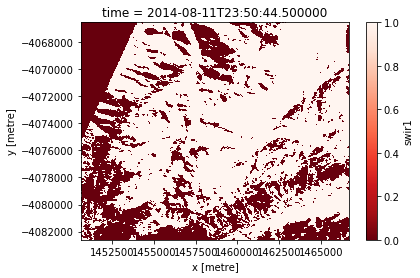

In [15]:
# Identify which pixels contain valid data in the Landsat dataset
valid_ds = np.isfinite(landsat_ds.swir1)

# Plot one sample timestep from the `valid_ds` dataset. Red below represents 
# invalid pixels, due to either issues with terrain shadow on steep mountains, 
# cloud cover, snow accidently mapped as cloud, or edges of Landsat overpasses
valid_ds.isel(time=85).plot(cmap='Reds_r')

## Compute Normalised Difference Snow Index (NDSI)

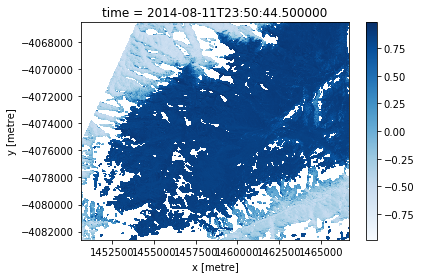

In [16]:
# Compute index by subtracting, summing and dividing the `green` and `swir` bands
ndsi_ds = (landsat_ds.green - landsat_ds.swir1) / (landsat_ds.green + landsat_ds.swir1)

# Plot one sample timestep from the NDSI dataset
ndsi_ds.isel(time=85).plot(cmap='Blues')

## Compute Normalised Difference Vegetation Index (NDVI)

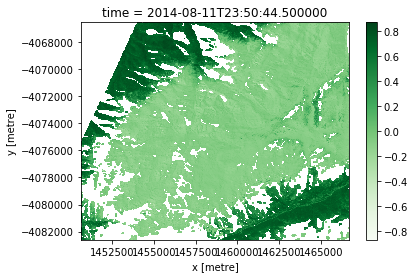

In [17]:
# Compute index by subtracting, summing and dividing the `green` and `swir` bands
ndvi_ds = (landsat_ds.nir - landsat_ds.red) / (landsat_ds.nir + landsat_ds.red)

# Plot one sample timestep from the NDSI dataset. Bright green values below 
# represent growing green vegetation
ndvi_ds.isel(time=85).plot(cmap='Greens')

### Threshold NDSI and NDVI to identify snowy, non-vegetated pixels

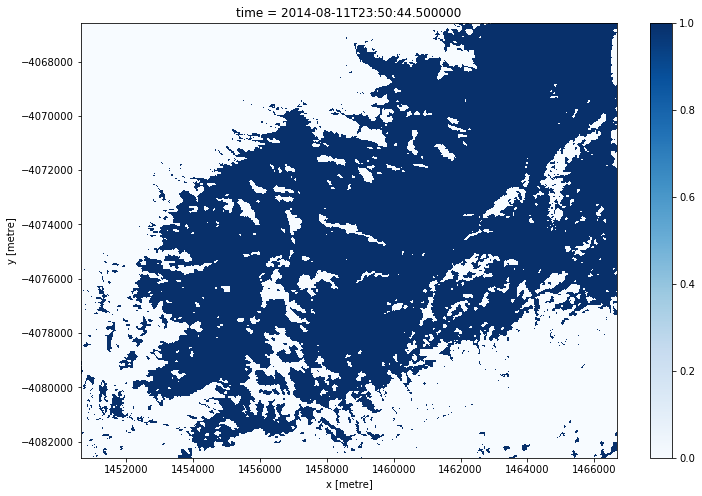

In [18]:
# Apply NDSI threshold defined above to identify snow (pixels with NDSI values greater than X)
snow_ds = ndsi_ds > ndsi_threshold

# Apply NDSI threshold defined above to identify snow (pixels with NDVI values less than X)
noveg_ds = ndvi_ds < ndvi_threshold

# Finally, keep only pixels that are both snowy AND non-vegetated:
snow_ds = noveg_ds & noveg_ds

# Plot the resulting layer
snow_ds.isel(time=85).plot(cmap='Blues', figsize=(12, 8))

## Compute time series of snow cover normalised by valid data

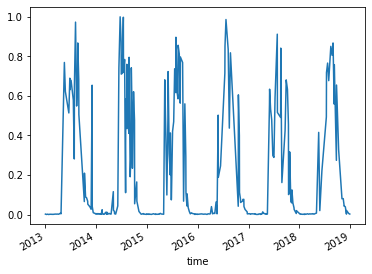

In [19]:
# First, calculate the number of snowy pixels in the study area for each timestep
snow_sum = snow_ds.sum(dim=['x', 'y'])

# Then calculate the number of pixels in the study area with valid data
# for each time step 
valid_sum = valid_ds.sum(dim=['x', 'y'])

# By dividing the number of snowy pixels by the number of valid pixels, we can
# compute a normalised percentage land cover that accounts for missing/invalid data
snow_prop = (snow_sum / valid_sum)

# Plot a line graph of snow cover across time as a proportion of the study area
snow_prop.plot()


#### Plot a smoothed time series
Due to issues with snow being confused for clouds in the satellite data, the above time series is very noisy and contains large fluctuations in the coverage of snow over short periods. To view a smoother, easier to interpret snow cover time series, we can take a rolling median of the data above. This will return the median of each observation and its four neighbours, resulting in a smoother dataset:

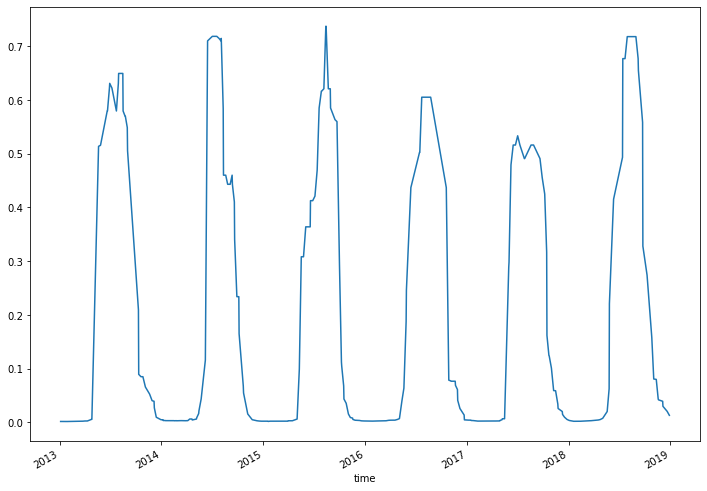

In [21]:
snow_prop.rolling(time=11, center=True, min_periods=1).median().plot(figsize=(12, 8))

## Plot snow accumulation for every pixel
As well as plotting a time series of snow cover across time, we can assess how frequently areas of the study area were covered by snow during the time period being analysed. 

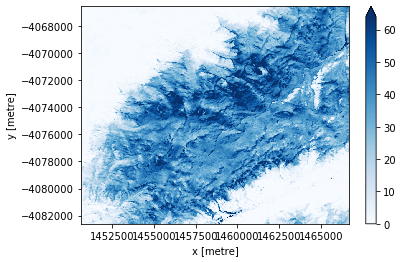

In [22]:
# This time, calculate the number of snowy observations for every pixel
# by taking a sum along the 'time' dimension
snow_sum_perpixel = snow_ds.sum(dim=['time'])

# Similarly, compute the number of valid observations for each pixel
# by taking the sum of valid observations along the 'time' dimension
valid_sum_perpixel = valid_ds.sum(dim=['time'])

# We can plot the raw number of snowy observations per pixel:
snow_sum_perpixel.plot(cmap='Blues', robust=True)

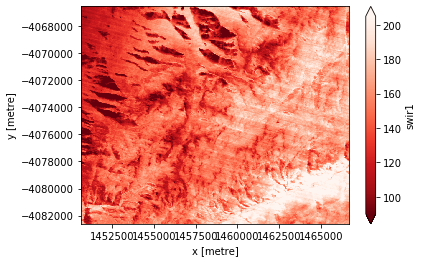

In [23]:
# We can also plot the number of valid observations for each pixel throughout 
# the time series. Red below represents pixels with very few valid observations, 
# due to either issues with terrain shadow, or snow being accidently mapped as cloud
valid_sum_perpixel.plot(cmap='Reds_r', robust=True)

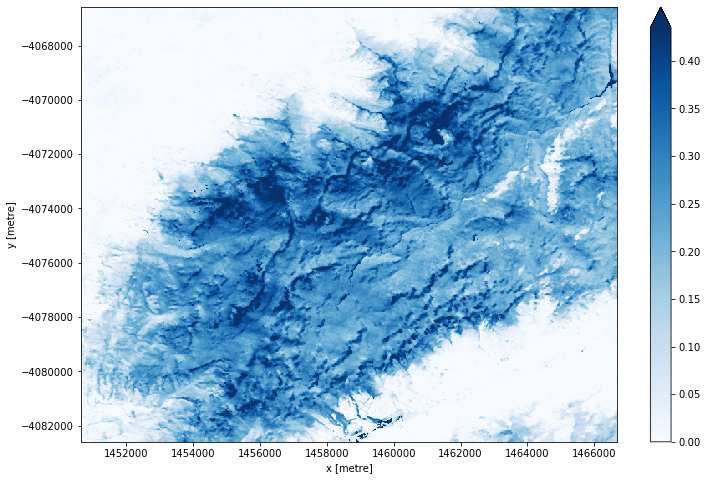

In [24]:
# Finally, we can normalise the raw number of snowy observations per pixel 
# by our total valid observations per pixel by dividing the two datasets:
snow_prop_perpixel = (snow_sum_perpixel / valid_sum_perpixel)

# Plot the resulting snow accumulation layer. The values here represent the 
# proportion of valid observations that each pixel was covered in snow, with
# blue colours representing pixels that were covered in snow for a significant
# portion of our valid observations:
snow_prop_perpixel.plot(cmap='Blues', robust=True, figsize=(12, 8))

## Advanced: compare snow extent elevation across time
Now that we have data on the distribution of snow for each satellite image, we can compare this to other datasets to provide more insights. Here we load a Digital Elevation Model dataset using the datacube, and use it to compare the elevation distribution of snow across time.

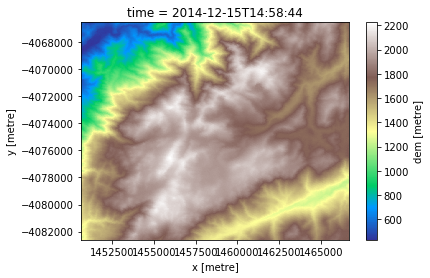

In [25]:
# Load the DEM data
dem_ds = dc.load(product='srtm_dem1sv1_0', **query)

# Plot the data
dem_ds.dem.plot(cmap='terrain')

We can return elevation data from the DEM for the area covered by snow in each timestep in our snow dataset:

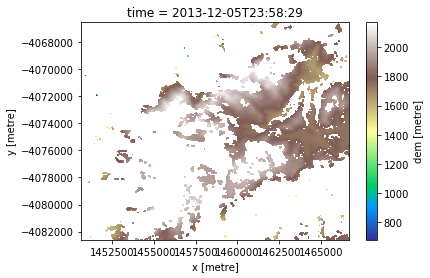

In [26]:
# Clip DEM to snow extent for every timestep
snow_elev_ds = dem_ds.dem.squeeze(dim='time').where(snow_ds)

# Plot example of clipped data for one timestep
snow_elev_ds.isel(time=40).plot(cmap='terrain')

We can plot the median elevation of the snow cover across time. However, this data can be extremely noisy, as it includes the elevation of small snow extents during summer and lower elevation pixels accidently mapped as snow:

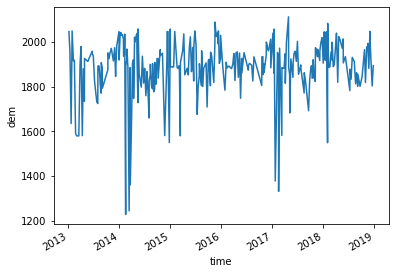

In [27]:
snow_elev_ts = snow_elev_ds.median(dim=['x', 'y'])
snow_elev_ts.plot()

A nicer way to visualise the data is using boxplots to summarise snow cover elevation for each year. This lets us compare the entire elevation range covered by snow annually:

Text(0.5, 0.98, 'Annual snow elevation distribution')

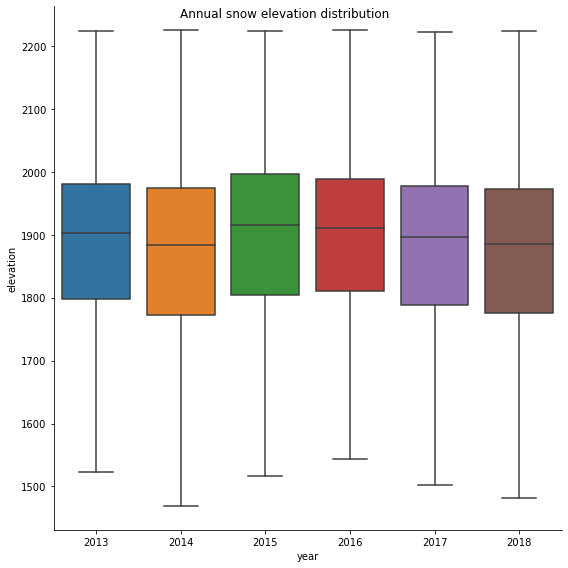

In [28]:
# Convert xarray data into a Pandas dataframe with one row per observation
snow_elev_df = (snow_elev_ds
                .stack(z=('x', 'y'))   # change the data from 4D (time, x, y) to 2D (time, location)
                .to_pandas()           # convert to a dataframe/table format
                .reset_index()         # turn the 'time' index into a normal column
                .melt(id_vars='time',  # rearrange the data to have one observation per row
                      value_name='elevation')
                .dropna()              # remove all empty observations (no snow)
                .sample(1000000))      # take a limited sample of rows to allow faster plotting

# Add a new column to allow summarising data by year
snow_elev_df['year'] = snow_elev_df.time.dt.year

# Plot each year's data as a boxplot to allow us to compare the elevation range
ax = sns.catplot(data=snow_elev_df, x='year', y='elevation', kind='box', showfliers=False, height=8)

# Add a title
ax.fig.suptitle('Annual snow elevation distribution')